In [1]:
%cd ..
# %cd ..
%env DWAVE_API_TOKEN=[]
# !source source.me

import os
from PIL import Image
import json
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
import torch
from torch import nn
import matplotlib.pyplot as plt

from hydra import initialize, compose
from nbutils import *
from dwave.system import DWaveSampler
%cd D-Wave

/home/blazerjia/beta_estimation/CaloQVAE/notebooks
env: DWAVE_API_TOKEN=DEV-ce582a09e21b2c15efc34a3001afcf1ef956bd03
/home/blazerjia/beta_estimation/CaloQVAE/notebooks/D-Wave


In [2]:
def rank_elements(lst):
    arr = np.array(lst)
    temp = np.argsort(arr)
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(arr))
    return ranks.tolist()
    
def reorder_dwave_samples(samples, reorder_index):
    reordered_samples = []
    for sample in samples:
        reordered_sample = sample[reorder_index]
        reordered_samples.append(reordered_sample)
    return np.array(reordered_samples)

In [3]:
gpu = 3
device = torch.device(f"cuda:{gpu}" if torch.cuda.is_available() else "cpu")
h = torch.load("h.pt")
J = torch.load("J.pt")
qubit_idxs = torch.load("qubit_idxs.pt")
idx_dict = torch.load("idx_dict.pt")
dwave_weights = torch.load("dwave_weights.pt")
dwave_bias = torch.load("dwave_bias.pt")
qpu_sampler = DWaveSampler(solver={'topology__type': 'pegasus',  "chip_id":"Advantage_system6.4"})


In [4]:
N_read = 128
start_time = time.time()

# This reorder index is only need to be calculated once, we can even do this during training when we have the qubit_idxs and save it to model.
reorder_index = rank_elements(qubit_idxs)
print("Time for ranking elements: {:.6f} seconds".format(time.time() - start_time))

start_time = time.time()

response = qpu_sampler.sample_ising(h, J, num_reads=N_read, answer_mode='raw', auto_scale=False)
print("Time for QPU sampling: {:.6f} seconds".format(time.time() - start_time))

start_time = time.time()
samples = response.record['sample']
print("Time for Loading samples: {:.6f} seconds".format(time.time() - start_time))

start_time = time.time()

reordered_samples = reorder_dwave_samples(samples, reorder_index)
print("Time for re-indexing D-Wave samples in new way: {:.6f} seconds".format(time.time() - start_time))

start_time = time.time()

dwave_samples, dwave_energies = batch_dwave_samples(response, qubit_idxs)
print("Time for re-indexing D-Wave samples in old way: {:.6f} seconds".format(time.time() - start_time))



N = 10
optimized_times = []
for i in range(N):
    start_time = time.time()

    reordered_samples = reorder_dwave_samples(samples, reorder_index)
    optimized_times.append(time.time() - start_time)

old_times = []
for i in range(N):
    start_time = time.time()

    dwave_samples, dwave_energies = batch_dwave_samples(response, qubit_idxs)
    old_times.append(time.time() - start_time)



Time for ranking elements: 0.000682 seconds
Time for QPU sampling: 0.128283 seconds
Time for Loading samples: 1.073885 seconds
Time for re-indexing D-Wave samples in new way: 0.011771 seconds
Time for re-indexing D-Wave samples in old way: 0.221501 seconds


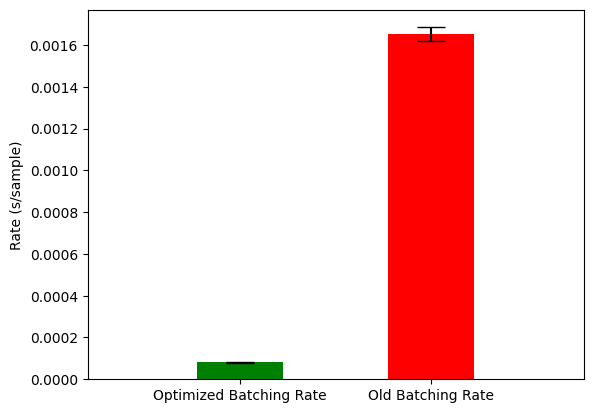

In [5]:
list1 = np.array(optimized_times)/N_read
list2 = np.array(old_times)/N_read

mean1, std1 = np.mean(list1), np.std(list1)
mean2, std2 = np.mean(list2), np.std(list2)


labels = ['Optimized Batching Rate', 'Old Batching Rate']

x = np.arange(len(labels)) 
width = 0.45

fig, ax = plt.subplots()
rects200 = ax.bar(x[0], mean1, width, yerr=std1, capsize=10, color='green')
rects201 = ax.bar(x[1], mean2, width, yerr=std2, capsize=10 , color='red')
ax.set_xlim(-0.8, 1.8)
ax.set_ylabel('Rate (s/sample)')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.show()

In [6]:
old_times

[0.20971989631652832,
 0.2091212272644043,
 0.2092740535736084,
 0.21212363243103027,
 0.21929168701171875,
 0.2129499912261963,
 0.20316529273986816,
 0.20914602279663086,
 0.21752500534057617,
 0.21078038215637207]

In [7]:
optimized_times

[0.011144161224365234,
 0.010854959487915039,
 0.010768651962280273,
 0.010637998580932617,
 0.01038503646850586,
 0.010448932647705078,
 0.010232686996459961,
 0.01003265380859375,
 0.010140180587768555,
 0.01023101806640625]